In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_data = pd.read_csv('zhengqi_train.txt', sep='\t')
test_data = pd.read_csv('zhengqi_test.txt', sep='\t')
train_data.head(3)

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V29,V30,V31,V32,V33,V34,V35,V36,V37,target
0,0.566,0.016,-0.143,0.407,0.452,-0.901,-1.812,-2.36,-0.436,-2.114,...,0.136,0.109,-0.615,0.327,-4.627,-4.789,-5.101,-2.608,-3.508,0.175
1,0.968,0.437,0.066,0.566,0.194,-0.893,-1.566,-2.36,0.332,-2.114,...,-0.128,0.124,0.032,0.600,-0.843,0.160,0.364,-0.335,-0.730,0.676
2,1.013,0.568,0.235,0.370,0.112,-0.797,-1.367,-2.36,0.396,-2.114,...,-0.009,0.361,0.277,-0.116,-0.843,0.160,0.364,0.765,-0.589,0.633


In [3]:
X = train_data.drop("target", axis=1)
y = train_data.target

In [4]:
def find_outliers(model, X, y, sigma=3):
    # 查找离群值
    # 标准偏差预先已知的情况
    # predict y values using model
    try:
        y_pred = pd.Series(model.predict(X), index=y.index)
    # if predicting fails, try fitting the model first
    except:
        model.fit(X, y)
        y_pred = pd.Series(model.predict(X), index=y.index)
        
    # calculate residuals between the model prediction and true y values
    resid = y - y_pred
    mean_resid = resid.mean()
    std_resid = resid.std()
    
    # calculate z statistic, define outliers to be where |z|>sigma
    z = (resid - mean_resid) / std_resid
    outliers = z[abs(z) > sigma].index
    
    # print and plot the results
    print('R2 =', model.score(X, y))
    print('mse =', mean_squared_error(y, y_pred))
    print('---------------------------------------')
    
    print('mean of residuals:', mean_resid)
    print('std of residuals:', std_resid)
    print('---------------------------------------')
    
    print(len(outliers), 'outliers: ')
    print(outliers.tolist())
    
    plt.figure(figsize=(15, 5))
    ax_131 = plt.subplot(1,3,1)
    plt.plot(y, y_pred, '.')
    plt.plot(y.loc[outliers], y_pred.loc[outliers], 'ro')
    # loc[1]是DataFrame的行索引, loc[1,2]是行列索引
    # o表示小圆圈，ro表示红色小圆圈
    plt.legend(['Accepted', 'Outlier'])
    plt.xlabel('y')
    plt.ylabel('y_pred')
    
    ax_132 = plt.subplot(1,3,2)
    plt.plot(y, y - y_pred, '.')
    plt.plot(y.loc[outliers], y.loc[outliers] - y_pred.loc[outliers], 'ro')
    plt.legend(['Accepted', 'Outlier'])
    plt.xlabel('y')
    plt.ylabel('y - y_pred')
    
    ax_133 = plt.subplot(1,3,3)
    z.plot.hist(bins=50, ax=ax_133)
    z.loc[outliers].plot.hist(color='r', bins=50, ax=ax_133)
    plt.legend(['Accepted', 'Outlier'])
    plt.xlabel('z')
    
    plt.show()
    
    return outliers

R2 = 0.8853726563655815
mse = 0.11094244665696637
---------------------------------------
mean of residuals: -4.982164265630896e-17
std of residuals: 0.3331379217948056
---------------------------------------
33 outliers: 
[321, 348, 376, 777, 884, 1145, 1164, 1310, 1523, 1537, 1704, 1874, 1879, 1905, 1979, 2002, 2159, 2160, 2264, 2279, 2528, 2620, 2645, 2647, 2667, 2668, 2669, 2696, 2767, 2769, 2807, 2842, 2863]


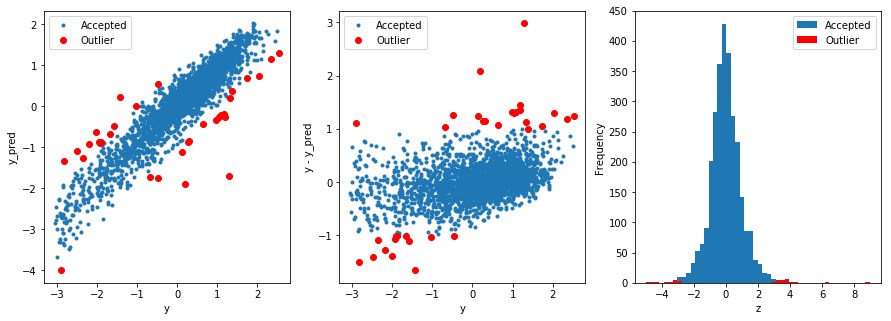

In [5]:
outliers = find_outliers(Ridge(), X, y)

X_outliers = X.loc[outliers]
y_outliers = y.loc[outliers]
X_t = X.drop(outliers)
y_t = y.drop(outliers)

In [18]:
rf_params1 = {'n_estimators': range(200, 261, 5)}
gsearch1 = GridSearchCV(RandomForestRegressor(max_depth=17,
                                              min_samples_split=7,
                                              min_samples_leaf=3,
                                              max_features=9,
                                              random_state=10),
                        param_grid=rf_params1, scoring='neg_mean_squared_error', 
                        iid=False, cv=5, verbose=1)

gsearch1.fit(X, y.values)
gsearch1.best_params_, gsearch1.best_score_
# n_estimators: 245
# score: 0.13540396543180816

Fitting 5 folds for each of 13 candidates, totalling 65 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:  2.0min finished


({'n_estimators': 245}, -0.13540396543180816)

In [19]:
rf_params2 = {'max_depth': range(15, 26, 1),
              'min_samples_split': range(4, 10, 1)}
gsearch2 = GridSearchCV(RandomForestRegressor(n_estimators=245,
                                              min_samples_leaf=3,
                                              max_features=9,
                                              random_state=10),
                        param_grid=rf_params2, scoring='neg_mean_squared_error', 
                        iid=False, cv=5, verbose=1)

gsearch2.fit(X, y.values)
gsearch2.best_params_, gsearch2.best_score_
# max_depth: 17, min_samples_split: 3
# score: 0.13540396543180816

Fitting 5 folds for each of 66 candidates, totalling 330 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 330 out of 330 | elapsed: 10.9min finished


({'max_depth': 17, 'min_samples_split': 7}, -0.13540396543180816)

In [22]:
rf1 = RandomForestRegressor(max_depth=17, n_estimators=245, max_features=9,
                            min_samples_leaf=3, min_samples_split=7, oob_score=True, random_state=10)
rf1.fit(X, y)
rf1.oob_score_

0.875373419509053

In [23]:
rf_params3 = {'min_samples_leaf': range(3, 12, 1),
              'min_samples_split': range(3, 12, 1)}
gsearch3 = GridSearchCV(RandomForestRegressor(max_depth=17,
                                              n_estimators=245,
                                              max_features=9, 
                                              random_state=10),
                        param_grid=rf_params3, scoring='neg_mean_squared_error', 
                        iid=False, cv=5, verbose=1)

gsearch3.fit(X, y.values)
gsearch3.best_params_, gsearch3.best_score_
# min_samples_leaf: 3, min_samples_split: 7
# score: 0.13540396543180816

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 405 out of 405 | elapsed: 11.4min finished


({'min_samples_leaf': 3, 'min_samples_split': 7}, -0.13540396543180816)

In [24]:
rf_params4 = {'max_features': range(3, 15, 1)}
gsearch4 = GridSearchCV(RandomForestRegressor(max_depth=17,
                                              min_samples_leaf=3,
                                              min_samples_split=7,
                                              n_estimators=245,
                                              random_state=10),
                        param_grid=rf_params4, scoring='neg_mean_squared_error', 
                        iid=False, cv=5, verbose=1)

gsearch4.fit(X, y.values)
gsearch4.best_params_, gsearch4.best_score_
# max_features: 9
# score: 0.13540396543180816

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  1.9min finished


({'max_features': 9}, -0.13540396543180816)

In [25]:
rf2 = RandomForestRegressor(max_depth=17, n_estimators=245, max_features=17,
                            min_samples_leaf=3, min_samples_split=7, oob_score=True)
rf2.fit(X, y.values)
rf2.oob_score_

0.8758099611863579

In [26]:
mean_squared_error(rf2.predict(X), y)

0.03308984361067274

In [27]:
test_data.head(3)

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37
0,0.368,0.380,-0.225,-0.049,0.379,0.092,0.550,0.551,0.244,0.904,...,-0.449,0.047,0.057,-0.042,0.847,0.534,-0.009,-0.190,-0.567,0.388
1,0.148,0.489,-0.247,-0.049,0.122,-0.201,0.487,0.493,-0.127,0.904,...,-0.443,0.047,0.560,0.176,0.551,0.046,-0.220,0.008,-0.294,0.104
2,-0.166,-0.062,-0.311,0.046,-0.055,0.063,0.485,0.493,-0.227,0.904,...,-0.458,-0.398,0.101,0.199,0.634,0.017,-0.234,0.008,0.373,0.569


In [30]:
ans = pd.DataFrame(rf2.predict(test_data))
ans.to_csv('RF_2.txt', index=False, header=False)

In [31]:
feature_importance_df = pd.DataFrame(columns=['Features', 'Importance'])
feature_importance_df.Features = X.columns.values
feature_importance_df.Importance = rf2.feature_importances_

In [32]:
X.columns

Index(['V0', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30',
       'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37'],
      dtype='object')

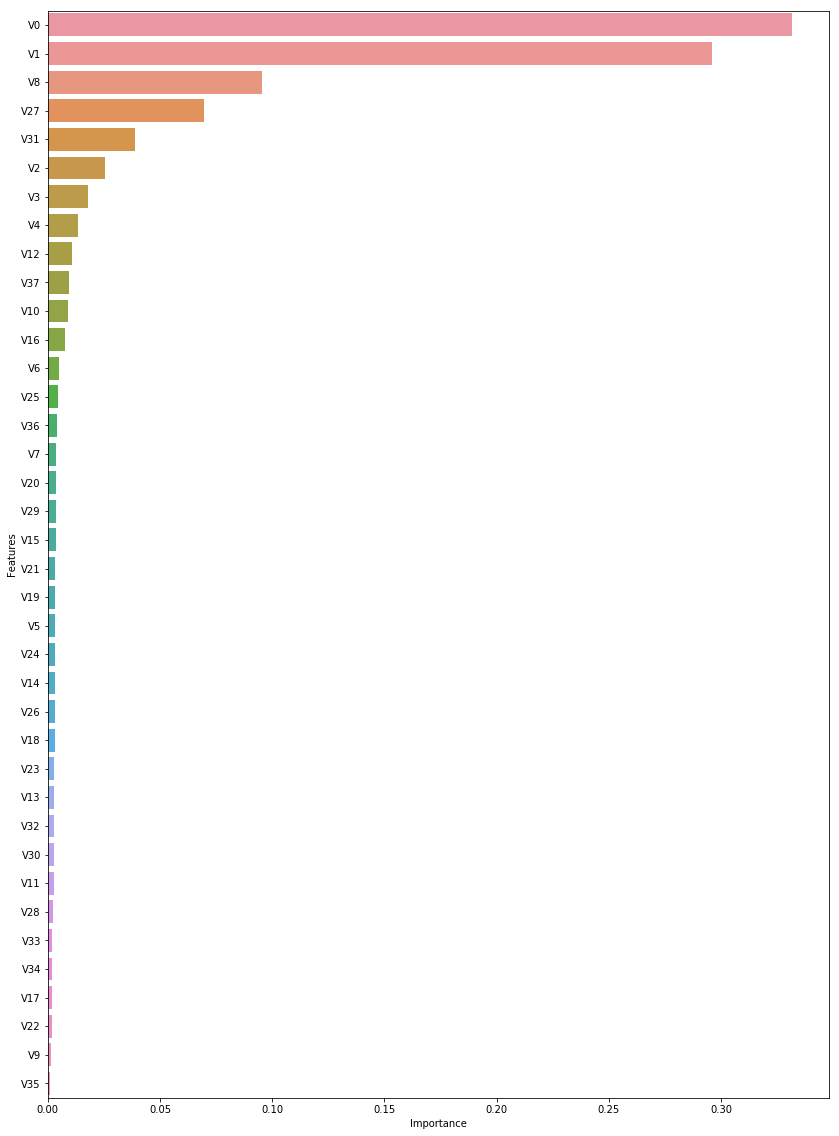

In [33]:
fig = plt.figure(figsize=(14, 20))
sns.barplot(x='Importance', y='Features', data=feature_importance_df.sort_values(by='Importance', ascending=False))
plt.show()